## Accessing Sentinel-3 SLSTR data with the Planetary Computer STAC API

The [Sentinel 3 SLSTR instrument](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-slstr) is a Along-Track Scanning Radiometer (ATSR) designed to provide reference land surface and sea surface temperatures.
There are three SLSTR collections in the Plantery Computer:

- Fire radiative power: `sentinel-3-slstr-frp-l2-netcdf`
- Land surface temperature: `sentinel-3-slstr-lst-l2-netcdf`
- Water surface temperature: `sentinel-3-slstr-wst-l2-netcdf`

This notebook demonstrates accessing and visualizing data from all three collections.

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.



### Land surface temperature

The collection's description provides more information about the LST product.

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-3-slstr-lst-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-slstr-lst-l2-netcdf

This Collection provides Sentinel-3 [SLSTR Level-2 Land Surface Temperature](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-lst) products containing data on land surface temperature measurements on a 1km grid. Radiance is measured in two channels to determine the temperature of the Earth's surface skin in the instrument field of view, where the term "skin" refers to the top surface of bare soil or the effective emitting temperature of vegetation canopies as viewed from above.

## Data files

The dataset includes data on the primary measurement variable, land surface temperature, in a single NetCDF file, `LST_in.nc`. A second file, `LST_ancillary.nc`, contains several ancillary variables:

- Normalized Difference Vegetation Index
- Surface biome classification
- Fractional vegetation cover
- Total water vapor column

In addition to the primary and ancillary data files, a standard set of annotation data files provide meteorological information, geolocation and time coordinates, geometry information, and quality flags. More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-lst) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-slstr/level-2/lst-processing).

This Collection contains Level-2 data in NetCDF files from April 2016 to present.

## STAC Item geometries

The Collection contains small "chips" and long "stripes" of data collected along the satellite direction of travel. Approximately five percent of the STAC Items describing long stripes of data contain geometries that encompass a larger area than an exact concave hull of the data extents. This may require additional filtering when searching the Collection for Items that spatially intersect an area of interest.


### Define the area of interest and search the land surface temperature collection

We'll search for items over the coordinates `[-105, 40]`.

In [2]:
import xarray as xr
import fsspec

search = catalog.search(
    collections=["sentinel-3-slstr-lst-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())

### Available Assets and Metadata

Each item includes a handful of assets linking to NetCDF files with the data or additional metadata files.

In [3]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                                                         ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lst-in             │ Land Surface Temperature (LST) values                                         │
│ slstr-met-tx       │ Meteorological parameters regridded onto the 16km tie points                  │
│ safe-manifest      │ SAFE product manifest                                                         │
│ slstr-time-in      │ Time annotations for the 1km grid                                             │
│ slstr-flags-in     │ Global flags for the 1km TIR grid, nadir view                                 │
│ lst-ancillary-ds   │ LST ancillary measurement dataset                                             │
│ slstr-indices-in   │ Scan, pixel and detector indices annotations for the 1km TIR grid, nadir view │
│ slstr-geodetic-in  │ Full resolution geodetic coordinates for the 1km TIR grid, nadir view         │
│ slstr-geodetic-tx  │ 16km geodetic coordinates                                                     │
│ slstr-geometry-tn  │ 16km solar and satellite geometry annotations, nadir view                     │
│ slstr-cartesian-in │ Full resolution cartesian coordinates for the 1km TIR grid, nadir view        │
│ slstr-cartesian-tx │ 16km cartesian coordinates                                                    │
└────────────────────┴───────────────────────────────────────────────────────────────────────────────┘

### Reading data

We can use xarray to read each NetCDF file directly from Blob Storage.

In [4]:
dataset = xr.open_dataset(fsspec.open(item.assets["lst-in"].href).open())
dataset

<xarray.Dataset>
Dimensions:                 (rows: 1200, columns: 1500, orphan_pixels: 187)
Dimensions without coordinates: rows, columns, orphan_pixels
Data variables:
    LST                     (rows, columns) float32 ...
    LST_orphan              (rows, orphan_pixels) float32 ...
    LST_uncertainty         (rows, columns) float32 ...
    LST_uncertainty_orphan  (rows, orphan_pixels) float32 ...
    exception               (rows, columns) int16 ...
    exception_orphan        (rows, orphan_pixels) int16 ...
Attributes: (12/17)
    absolute_orbit_number:  37494
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20230501T144125Z
    history:                  2023-05-01T14:41:25Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    source:                 IPF-SL-2 06.21
    start_offset:           44020
    start_time:             2023-04-30T04:39:31.438126Z
    stop_time:              2023-04-30T04:42:31.129854Z
    title:                  SLSTR Level 2 Product, Land Surface Temperature m...
    track_offset:           998

### Geolocating and subsetting the data

To plot the land surface temperature data, we will use the georeferencing information contained in the `slstr-geodetic-in` asset.
There's so many points, and the data have such a large spatial extent, that we only need a random sample of the data rather than every point.

In [5]:
geo = xr.open_dataset(fsspec.open(item.assets["slstr-geodetic-in"].href).open()).load()
geo

<xarray.Dataset>
Dimensions:              (rows: 1200, columns: 1500, orphan_pixels: 187)
Dimensions without coordinates: rows, columns, orphan_pixels
Data variables:
    elevation_in         (rows, columns) float32 nan nan nan nan ... nan nan nan
    elevation_orphan_in  (rows, orphan_pixels) float32 326.0 330.0 ... nan nan
    latitude_in          (rows, columns) float64 33.52 33.52 33.52 ... 41.1 41.1
    latitude_orphan_in   (rows, orphan_pixels) float64 33.0 32.97 ... nan nan
    longitude_in         (rows, columns) float64 -94.72 -94.73 ... -114.2 -114.2
    longitude_orphan_in  (rows, orphan_pixels) float64 -98.74 -98.9 ... nan nan
Attributes: (12/17)
    absolute_orbit_number:  37494
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20230501T144125Z
    history:                  2023-05-01T14:41:25Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    source:                 IPF-SL-2 06.21
    start_offset:           44020
    start_time:             2023-04-30T04:39:31.438126Z
    stop_time:              2023-04-30T04:42:31.129854Z
    title:                  S3 SLSTR L1 Radiance and Brightness Temperatures ...
    track_offset:           998

In [6]:
import pandas

data = (
    pandas.DataFrame(
        {
            "longitude": geo.longitude_in.data.ravel(),
            "latitude": geo.latitude_in.data.ravel(),
            "lst": dataset.LST.load().data.ravel(),
        }
    )
    .dropna()
    .sample(10000)
)
data

,longitude,latitude,lst
1020954,-106.477214,37.928197,274.365997
1210376,-111.487024,38.031391,272.294006
1078016,-107.259553,38.127250,274.444000
861178,-97.549408,38.335761,276.816010
1055490,-106.929072,38.053571,267.406006
...,...,...,...
424405,-110.153256,33.394046,287.675995
371951,-110.523054,32.971659,292.160004
1170842,-105.485691,39.043829,245.289993
255360,-98.851436,34.515057,283.153992


### Plotting land surface temperature data

We use a scatter plot to visualize the land surface temperature points over the globe.
We also plot the item geometry, to give us a sense of the satellite's field of view and where that field of view crosses the land.

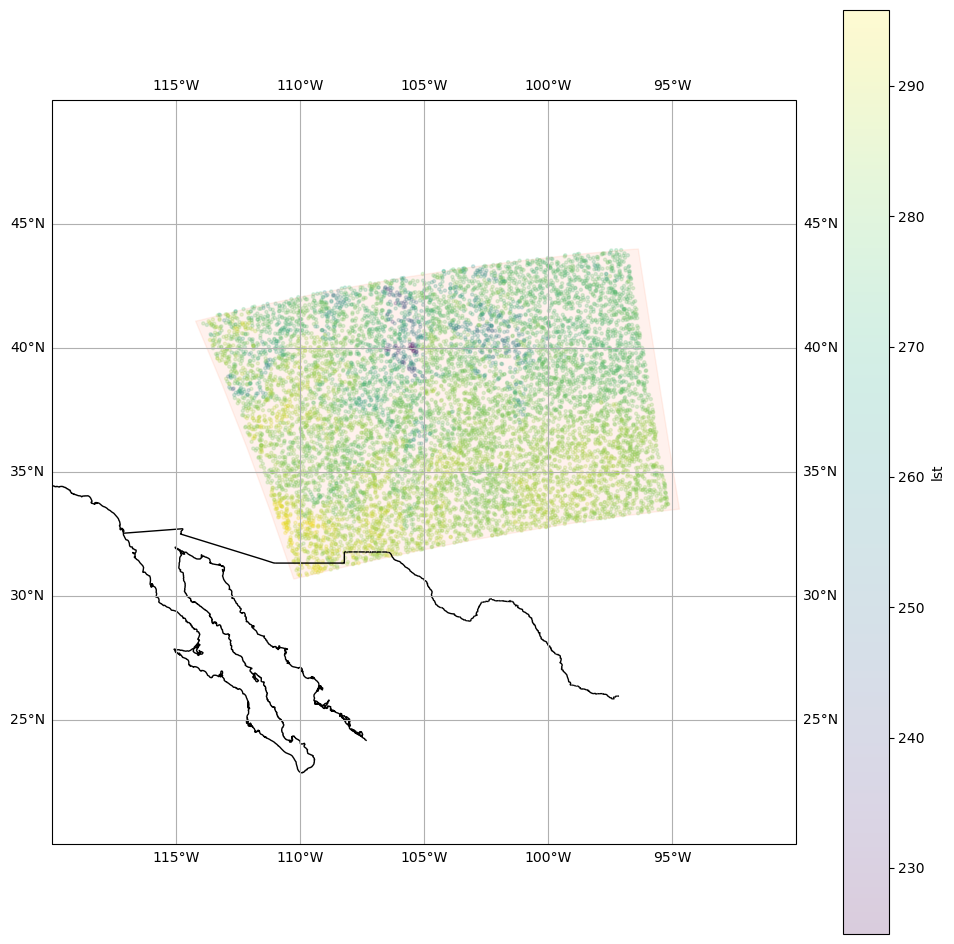

In [7]:
import shapely.geometry
from cartopy.crs import PlateCarree
from cartopy.feature import BORDERS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=PlateCarree()))

ax.add_geometries(
    shapely.geometry.shape(item.geometry), crs=PlateCarree(), color="coral", alpha=0.1
)

data.plot.scatter(
    x="longitude",
    y="latitude",
    c="lst",
    ax=ax,
    colormap="viridis",
    marker=".",
    alpha=0.2,
)
ax.set(ybound=(20, 50), xbound=(-120, -90))
ax.coastlines()
ax.add_feature(BORDERS, linestyle="-")
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);

### Water surface temperature data

Let's do the same process, but for the water surface temperature product.
The data structure is a little different.

In [8]:
collection = catalog.get_collection("sentinel-3-slstr-wst-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-slstr-wst-l2-netcdf

This Collection provides Sentinel-3 [SLSTR Level-2 Water Surface Temperature](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-wst) products containing data on sea surface temperature measurements on a 1km grid. Each product consists of a single NetCDF file containing all data variables:

- Sea Surface Temperature (SST) value
- SST total uncertainty
- Latitude and longitude coordinates
- SST time deviation
- Single Sensor Error Statistic (SSES) bias and standard deviation estimate
- Contextual parameters such as wind speed at 10 m and fractional sea-ice contamination
- Quality flag
- Satellite zenith angle
- Top Of Atmosphere (TOA) Brightness Temperature (BT)
- TOA noise equivalent BT

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-wst) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-slstr/level-2/sst-processing).

This Collection contains Level-2 data in NetCDF files from October 2017 to present.


In [9]:
search = catalog.search(
    collections=["sentinel-3-slstr-wst-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key           ┃ Value                                                                                           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ l2p           │ Skin Sea Surface Temperature (SST) values                                                       │
│ browse-jpg    │ Preview image produced by the European Organisation for the Exploitation of Meteorological      │
│               │ Satellites (EUMETSAT)                                                                           │
│ eop-metadata  │ Metadata produced by the European Organisation for the Exploitation of Meteorological           │
│               │ Satellites (EUMETSAT)                                                                           │
│ safe-manifest │ SAFE product manifest                                                                           │
└───────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────┘

In [10]:
dataset = xr.open_dataset(fsspec.open(item.assets["l2p"].href).open())
dataset

<xarray.Dataset>
Dimensions:                            (time: 1, nj: 40394, ni: 1500, channel: 3)
Coordinates:
    lat                                (nj, ni) float32 ...
    lon                                (nj, ni) float32 ...
  * time                               (time) datetime64[ns] 2023-04-26T04:08:58
Dimensions without coordinates: nj, ni, channel
Data variables: (12/22)
    adi_dtime_from_sst                 (time, nj, ni) float32 ...
    aerosol_dynamic_indicator          (time, nj, ni) float32 ...
    brightness_temperature             (channel, time, nj, ni) float32 ...
    dt_analysis                        (time, nj, ni) float32 ...
    dual_nadir_sst_difference          (time, nj, ni) float32 ...
    l2p_flags                          (time, nj, ni) int16 ...
    ...                                 ...
    sses_standard_deviation            (time, nj, ni) float32 ...
    sst_algorithm_type                 (time, nj, ni) int8 ...
    sst_dtime                          (time, nj, ni) timedelta64[ns] ...
    sst_theoretical_uncertainty        (time, nj, ni) float32 ...
    wind_speed                         (time, nj, ni) float32 ...
    wind_speed_dtime_from_sst          (time, nj, ni) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    acknowledgment:             European Commission Copernicus Programme
    cdm_data_type:              swath
    comment:                    GHRSST SST L2P
    creator_email:              ops@eumetsat.int
    ...                         ...
    summary:                    Sentinel-3A SLSTR skin sea surface temperature
    time_coverage_end:          20230426T054956Z
    time_coverage_start:        20230426T040858Z
    title:                      Sentinel-3A SLSTR L2P SST dataset
    uuid:                       TBC
    westernmost_longitude:      -178.58172607421875

In [11]:
import pandas

data = (
    pandas.DataFrame(
        {
            "longitude": dataset.lon.data.ravel(),
            "latitude": dataset.lat.data.ravel(),
            "sea_surface_temperature": dataset.sea_surface_temperature.load().data.ravel(),
        }
    )
    .dropna()
    .sample(10000)
)
data

,longitude,latitude,sea_surface_temperature
14291493,-97.294258,-5.197991,300.820007
42867585,68.544571,15.891827,303.279999
5517750,-77.549706,-55.720612,279.479980
54869107,46.689182,-54.085552,272.519989
8737663,-80.118530,-35.690479,286.100006
...,...,...,...
17576687,-103.380623,13.824631,302.320007
47112414,61.504601,-8.788809,302.169983
17712804,-100.103874,15.390665,301.239990
5239043,-81.084801,-58.172470,281.130005


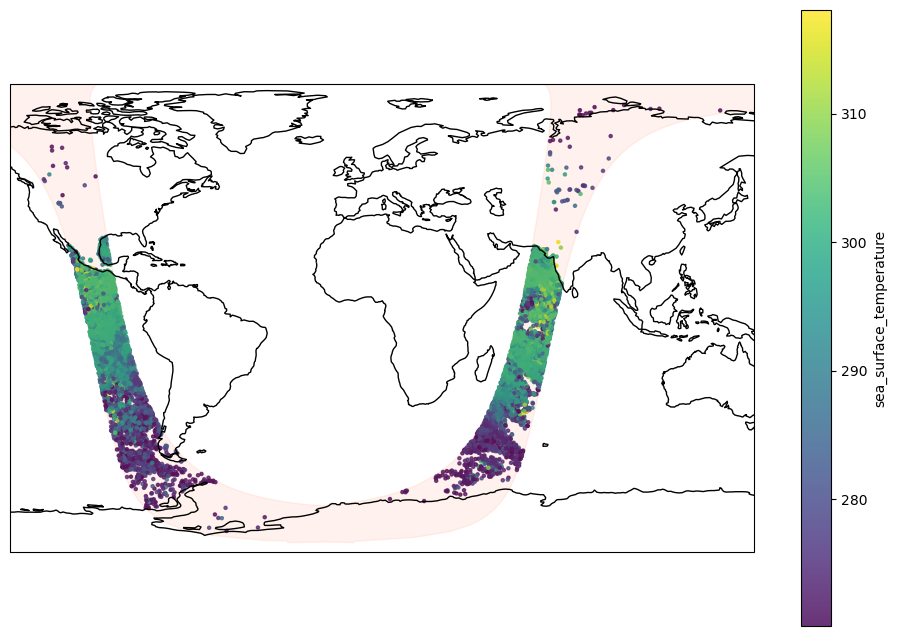

In [12]:
figure, axes = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=PlateCarree()))

axes.add_geometries(
    shapely.geometry.shape(item.geometry), crs=PlateCarree(), color="coral", alpha=0.1
)

data.plot.scatter(
    x="longitude",
    y="latitude",
    c="sea_surface_temperature",
    ax=axes,
    colormap="viridis",
    marker=".",
    alpha=0.8,
)
axes.coastlines();

### Fire radiative power

We'll do the same for fire radiative power.
This product's items are smaller chips.
Let's use an item that crosses over California to give ourselves the best chance of catching data of interest.

In [13]:
collection = catalog.get_collection("sentinel-3-slstr-frp-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-slstr-frp-l2-netcdf

This Collection provides Sentinel-3 [SLSTR Level-2 Fire Radiative Power](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-frp) (FRP) products containing data on fires detected over land and ocean.

## Data files

The primary measurement data is contained in the `FRP_in.nc` file and provides FRP and uncertainties, projected onto a 1km grid, for fires detected in the thermal infrared (TIR) spectrum over land. Since February 2022, FRP and uncertainties are also provided for fires detected in the short wave infrared (SWIR) spectrum over both land and ocean, with the delivered data projected onto a 500m grid. The latter SWIR-detected fire data is only available for night-time measurements and is contained in the `FRP_an.nc` or `FRP_bn.nc` files.

In addition to the measurement data files, a standard set of annotation data files provide meteorological information, geolocation and time coordinates, geometry information, and quality flags.

## Processing

The TIR fire detection is based on measurements from the S7 and F1 bands of the [SLSTR instrument](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-3-slstr/instrument); SWIR fire detection is based on the S5 and S6 bands. More information about the product and data processing can be found in the [User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-slstr/product-types/level-2-frp) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-slstr/level-2/frp-processing).

This Collection contains Level-2 data in NetCDF files from August 2020 to present.


In [14]:
search = catalog.search(
    collections=["sentinel-3-slstr-frp-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-121, 40]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                                                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ frp-in             │ Fire Radiative Power (FRP) dataset                                     │
│ slstr-met-tx       │ Meteorological parameters regridded onto the 16km tie points           │
│ safe-manifest      │ SAFE product manifest                                                  │
│ slstr-time-in      │ Time annotations for the 1 KM grid                                     │
│ slstr-flags-fn     │ Global flags for the 1km F1 grid, nadir view                           │
│ slstr-flags-in     │ Global flags for the 1km TIR grid, nadir view                          │
│ slstr-indices-fn   │ Scan, pixel and detector annotations for the 1km F1 grid, nadir view   │
│ slstr-indices-in   │ Scan, pixel and detector annotations for the 1km TIR grid, nadir view  │
│ slstr-geodetic-fn  │ Full resolution geodetic coordinates for the 1km F1 grid, nadir view   │
│ slstr-geodetic-in  │ Full resolution geodetic coordinates for the 1km TIR grid, nadir view  │
│ slstr-geodetic-tx  │ 16km geodetic coordinates                                              │
│ slstr-geometry-tn  │ 16km solar and satellite geometry annotations, nadir view              │
│ slstr-cartesian-fn │ Full resolution cartesian coordinates for the 1km F1 grid, nadir view  │
│ slstr-cartesian-in │ Full resolution cartesian coordinates for the 1km TIR grid, nadir view │
│ slstr-cartesian-tx │ 16km cartesian coordinates                                             │
└────────────────────┴────────────────────────────────────────────────────────────────────────┘

In [15]:
dataset = xr.open_dataset(fsspec.open(item.assets["frp-in"].href).open())
dataset

<xarray.Dataset>
Dimensions:                 (fires: 88, rows: 1200, columns: 1500)
Dimensions without coordinates: fires, rows, columns
Data variables: (12/25)
    BT_MIR                  (fires) float64 ...
    BT_window               (fires) float64 ...
    Day_night               (fires) int8 ...
    F1_Fire_pixel_radiance  (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    ...                      ...
    n_cloud                 (fires) int16 ...
    n_water                 (fires) int16 ...
    n_window                (fires) int16 ...
    time                    (fires) datetime64[ns] ...
    transmittance_MWIR      (fires) float64 ...
    used_channel            (fires) uint8 ...
Attributes: (12/17)
    absolute_orbit_number:  26107
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20230501T123812Z
    history:                  2023-05-01T12:38:12Z: PUGCoreProcessor JobOrder...
    institution:            PS2
    ...                     ...
    source:                 IPF-SL-2-FRP 01.08
    start_offset:           56043
    start_time:             2023-04-30T17:58:15.260256Z
    stop_time:              2023-04-30T18:01:14.953810Z
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    track_offset:           998

In [16]:
import pandas

data = pandas.DataFrame(
    {
        "longitude": dataset.longitude.data.ravel(),
        "latitude": dataset.latitude.data.ravel(),
        "radiance": dataset.F1_Fire_pixel_radiance.load().data.ravel(),
    }
).dropna()
data

,longitude,latitude,radiance
0,-113.659809,39.688016,0.918481
1,-111.476330,38.801270,11.352760
2,-111.464705,38.799932,2.332020
3,-118.064226,39.264368,1.464294
4,-121.641641,39.083807,1.075822
...,...,...,...
83,-114.843571,33.928673,1.640789
84,-114.845418,33.919861,1.625753
85,-114.835000,33.917116,1.606819
86,-110.983447,29.555228,2.122387


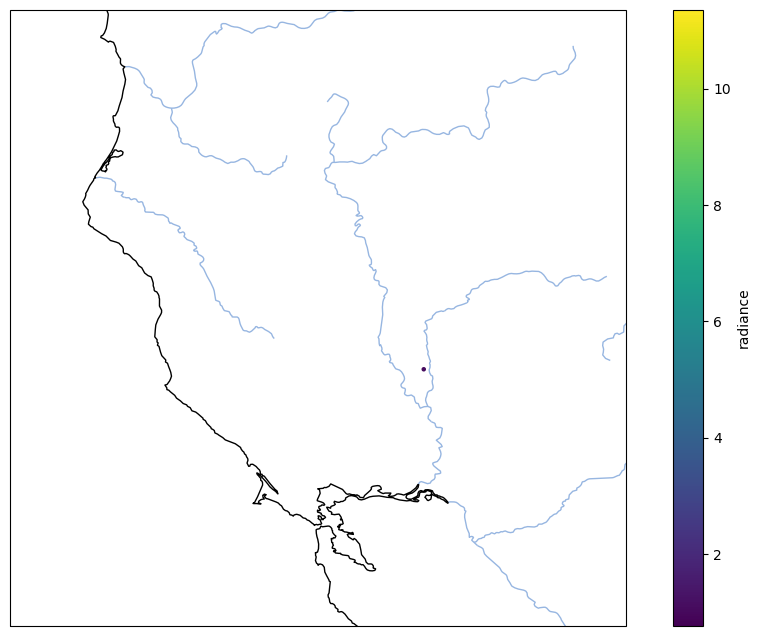

In [17]:
from cartopy.feature import RIVERS, COASTLINE

figure, axes = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=PlateCarree()))

axes.add_feature(RIVERS)
axes.add_feature(COASTLINE)
data.plot.scatter(
    x="longitude", y="latitude", c="radiance", ax=axes, colormap="viridis", marker="."
)
axes.set_extent((-125, -120, 37, 42));